In [1]:
import sys
sys.path.insert(0, '../')
from models.custom import AHOY

ahoy_ir = AHOY("../weights/yolov5n_IR.pt", "../weights/yolov5h_IR.pt", fp16=True)
ahoy_rgb = AHOY("../weights/yolov5n6.pt", "../weights/yolov5h6.pt", fp16=True)

🚀 SEA.AI custom version


YOLOv5 🚀 v7.0-320-g42190245 Python-3.10.11 torch-2.1.0 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11004MiB)

Fusing layers... 
Model summary: 157 layers, 1771342 parameters, 0 gradients, 4.2 GFLOPs
Loaded weights from ../weights/yolov5n_IR.pt
YOLOv5 🚀 v7.0-320-g42190245 Python-3.10.11 torch-2.1.0 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11004MiB)

Fusing layers... 
Model summary: 93 layers, 2818424 parameters, 0 gradients, 4.2 GFLOPs
Loaded weights from ../weights/yolov5h_IR.pt
YOLOv5 🚀 v7.0-320-g42190245 Python-3.10.11 torch-2.1.0 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11004MiB)

YOLOv5 🚀 v7.0-320-g42190245 Python-3.10.11 torch-2.1.0 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11004MiB)

Fusing layers... 
Model summary: 206 layers, 3102712 parameters, 0 gradients, 4.3 GFLOPs
Loaded weights from ../weights/yolov5n6.pt
YOLOv5 🚀 v7.0-320-g42190245 Python-3.10.11 torch-2.1.0 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11004MiB)

Fusing layers... 
Model summary: 108 layers, 3353720 parameters, 0 gradients, 4.6 GFLOPs
Lo

In [2]:
from models.custom import DAN
dan = DAN(rgb_model=ahoy_rgb, ir_model=ahoy_ir)

In [5]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from PIL import Image
import torch

from utils.general import non_max_suppression
from utils.horizon import draw_horizon, draw_bboxes
from inference.preprocessing import letterbox_image

image_ir = np.array(Image.open("../examples/example_1_IR.jpg").convert("RGB"))
imgsz_ir = 640
image_rgb = np.array(Image.open("../examples/example_1.jpg").convert("RGB"))
imgsz_rgb = 1280

def postprocess_x_pitch_theta(x_pitch, x_theta):
    # curve fitting
    def gaussian(x, A, mu, sigma):
        return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

    x_pitch = x_pitch.squeeze().cpu().numpy()
    x_theta = x_theta.squeeze().cpu().numpy()

    # Initial guess for the parameters (amplitude, mean, standard deviation)
    pitch0 = [x_pitch.max(), x_pitch.argmax() / x_pitch.shape[-1], 0.001]
    theta0 = [x_theta.max(), x_theta.argmax() / x_theta.shape[-1], 0.001]

    x_data = np.linspace(0, 1, x_pitch.shape[0], endpoint=False)
    params_pitch, cov_pitch = curve_fit(gaussian, x_data, x_pitch, p0=pitch0)
    params_theta, cov_theta = curve_fit(gaussian, x_data, x_theta, p0=theta0)

    return params_pitch[1], params_theta[1]

def postprocess_dets(
        dets,
        conf_thres=0.25,
        iou_thres=0.1,
        classes=None,
        agnostic_nms=True,
        max_det=100
):           
    dets = non_max_suppression(dets, conf_thres, iou_thres, classes, agnostic_nms, max_det=max_det)
    return dets[0].cpu().numpy()

def preprocess(image, imgsz):
    x = letterbox_image(image, desired_size=(imgsz, imgsz))
    x = torch.from_numpy(x).permute(2,0,1).unsqueeze(0)
    x = x.to(ahoy_rgb.device)
    x = x.half() if ahoy_rgb.fp16 else x.float()
    x /= 255.0
    return x

with torch.no_grad():
    x_rgb = preprocess(image_rgb, imgsz_rgb)
    x_ir = preprocess(image_ir, imgsz_ir)

    (dets_rgb, x_pitch_rgb, x_theta_rgb), (dets_ir, x_pitch_ir, x_theta_ir) = dan(x_rgb, x_ir)

    dets_rgb = postprocess_dets(dets_rgb)
    dets_ir = postprocess_dets(dets_ir)

    pitch_rgb, theta_rgb = postprocess_x_pitch_theta(x_pitch_rgb, x_theta_rgb)
    pitch_ir, theta_ir = postprocess_x_pitch_theta(x_pitch_ir, x_theta_ir)

AttributeError: 'tuple' object has no attribute 'shape'

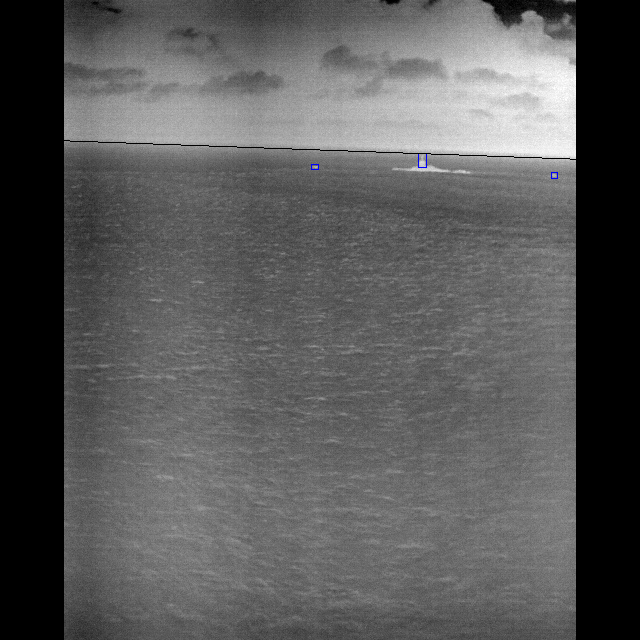

In [7]:
I = letterbox(image_ir, target_shape=imgsz_ir)[0]
diameter = 1
I = draw_bboxes(I, dets_ir, color=(0,0,255), thickness=1)
# I = draw_horizon(I, pitch_theta=(target[0][0], target[0][1]), color=(0,255,0), diameter=diameter)
I = draw_horizon(I, pitch_theta=(pitch_ir, theta_ir), color=(0,0,0), diameter=diameter)
I = Image.fromarray(I)
I #.reduce(2) if I.width >= 1024 else I

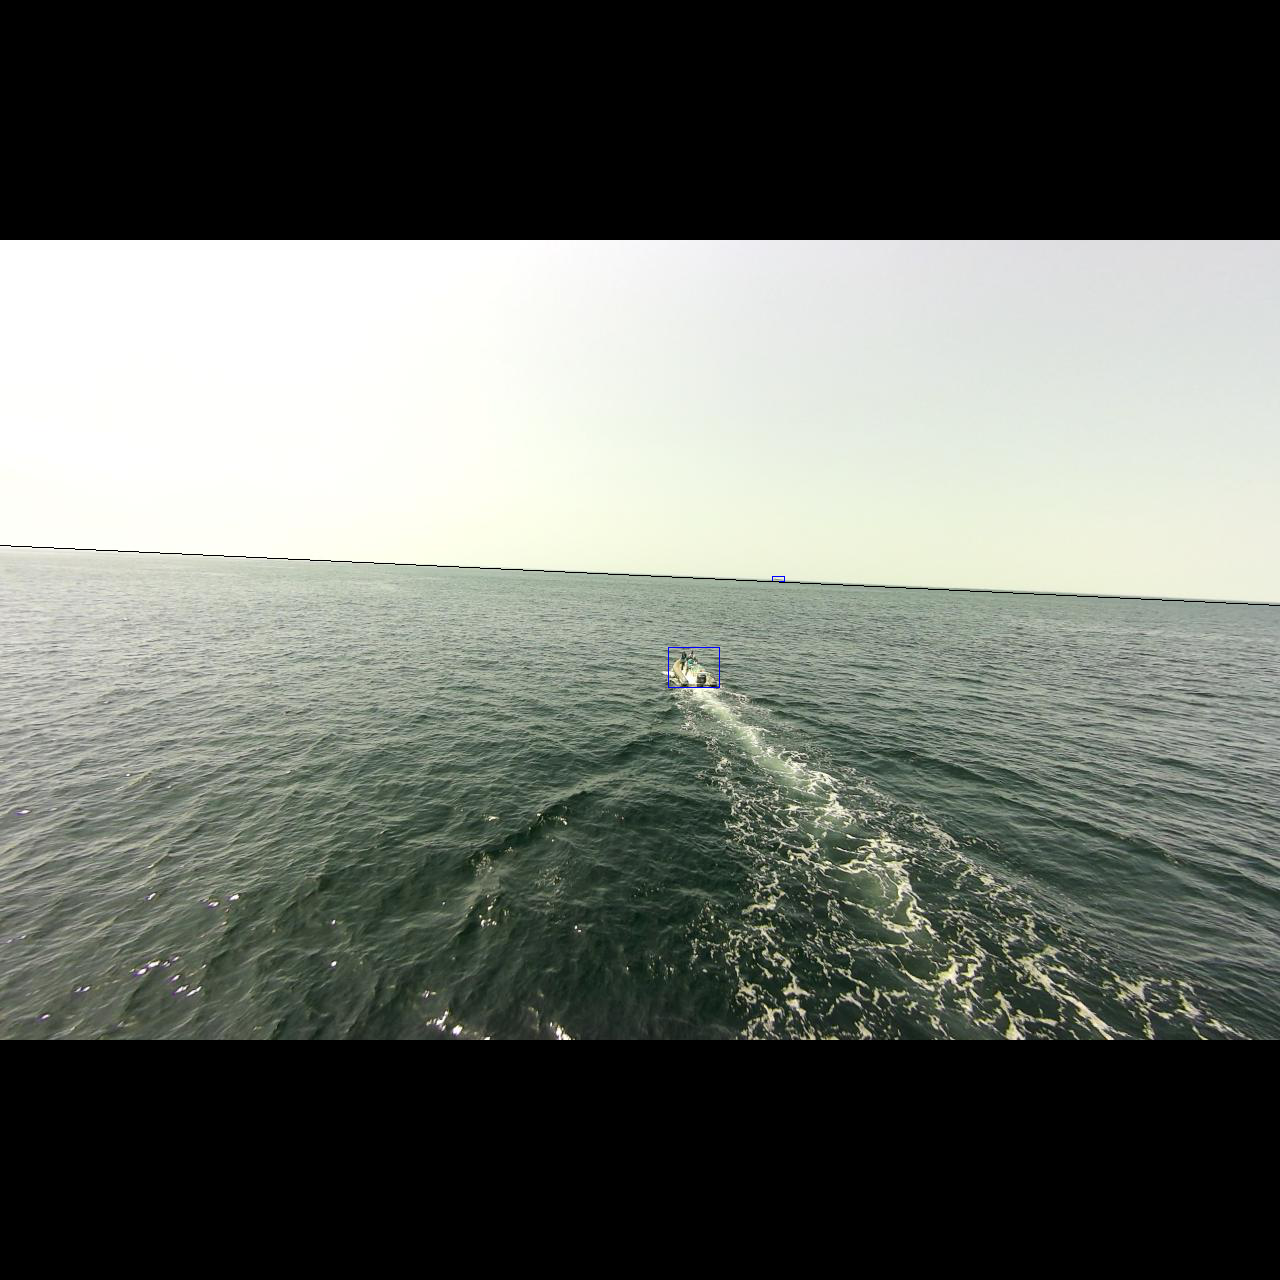

In [8]:
I = letterbox(image_rgb, target_shape=imgsz_rgb)[0]
diameter = 1
I = draw_bboxes(I, dets_rgb, color=(0,0,255), thickness=1)
# I = draw_horizon(I, pitch_theta=(target[0][0], target[0][1]), color=(0,255,0), diameter=diameter)
I = draw_horizon(I, pitch_theta=(pitch_rgb, theta_rgb), color=(0,0,0), diameter=diameter)
I = Image.fromarray(I)
I #.reduce(2) if I.width >= 1024 else I

In [6]:
from pathlib import Path
from export import export_engine
from models.yolo import Detect

inplace = False # default=False
dynamic = False # default=False
batch_size = 2
name = f"dan_b{batch_size}"

# Update model
dan.eval()
for k, m in dan.named_modules():
    if isinstance(m, Detect):
        m.inplace = inplace
        m.dynamic = dynamic
        m.export = True

img_ir = torch.zeros((batch_size, 3, imgsz_ir, imgsz_ir), device=dan.device)
img_rgb = torch.zeros((batch_size, 3, imgsz_rgb, imgsz_rgb), device=dan.device)
export_engine(
    dan,
    im=tuple(im.half() if dan.fp16 else im for im in (img_rgb, img_ir)),
    file=Path(name),
    half=dan.fp16,
    #opset=12,
    dynamic=dynamic,
    simplify=False,
)


ONNX: starting export with onnx 1.13.1...
/home/kevinserrano/GitHub/yolov5/horizon/../models/yolo.py:153: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if profile:
/home/kevinserrano/GitHub/yolov5/horizon/../models/yolo.py:157: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if visualize:
/home/kevinserrano/GitHub/yolov5/horizon/../models/yolo.py:157: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This

[02/29/2024-21:58:14] [TRT] [I] [MemUsageChange] Init CUDA: CPU +500, GPU +0, now: CPU 3820, GPU 1528 (MiB)
[02/29/2024-21:58:18] [TRT] [I] [MemUsageChange] Init builder kernel library: CPU +883, GPU +172, now: CPU 4779, GPU 1700 (MiB)
[02/29/2024-21:58:18] [TRT] [W] CUDA lazy loading is not enabled. Enabling it can significantly reduce device memory usage and speed up TensorRT initialization. See "Lazy Loading" section of CUDA documentation https://docs.nvidia.com/cuda/cuda-c-programming-guide/index.html#lazy-loading
[02/29/2024-21:58:18] [TRT] [I] ----------------------------------------------------------------
[02/29/2024-21:58:18] [TRT] [I] Input filename:   dan_b2.onnx
[02/29/2024-21:58:18] [TRT] [I] ONNX IR version:  0.0.7
[02/29/2024-21:58:18] [TRT] [I] Opset version:    12
[02/29/2024-21:58:18] [TRT] [I] Producer name:    pytorch
[02/29/2024-21:58:18] [TRT] [I] Producer version: 2.1.0
[02/29/2024-21:58:18] [TRT] [I] Domain:           
[02/29/2024-21:58:18] [TRT] [I] Model versi

[02/29/2024-22:06:30] [TRT] [I] Detected 2 inputs and 13 output network tensors.
[02/29/2024-22:06:31] [TRT] [I] Total Host Persistent Memory: 1070608
[02/29/2024-22:06:31] [TRT] [I] Total Device Persistent Memory: 5529600
[02/29/2024-22:06:31] [TRT] [I] Total Scratch Memory: 0
[02/29/2024-22:06:31] [TRT] [I] [MemUsageStats] Peak memory usage of TRT CPU/GPU memory allocators: CPU 11 MiB, GPU 400 MiB
[02/29/2024-22:06:31] [TRT] [I] [BlockAssignment] Started assigning block shifts. This will take 362 steps to complete.
[02/29/2024-22:06:31] [TRT] [I] [BlockAssignment] Algorithm ShiftNTopDown took 30.5862ms to assign 15 blocks to 362 nodes requiring 114186752 bytes.
[02/29/2024-22:06:31] [TRT] [I] Total Activation Memory: 114186240


TensorRT: export success ✅ 500.1s, saved as dan_b2.engine (28.5 MB)


[02/29/2024-22:06:31] [TRT] [I] [MemUsageChange] TensorRT-managed allocation in building engine: CPU +4, GPU +27, now: CPU 4, GPU 27 (MiB)


(PosixPath('dan_b2.engine'), None)

In [6]:
! ls -lh

total 37M
-rw-rw-r-- 1 kevinserrano kevinserrano  17M Dez 24 12:52 ahoy.engine
-rw-rw-r-- 1 kevinserrano kevinserrano  14M Dez 24 12:45 ahoy.onnx
-rw-rw-r-- 1 kevinserrano kevinserrano 7,3K Nov  6 17:23 dataloaders.py
-rw-rw-r-- 1 kevinserrano kevinserrano  14K Dez 24 12:11 models.py
-rw-rw-r-- 1 kevinserrano kevinserrano 524K Okt 19 01:56 playground.ipynb
drwxrwxr-x 2 kevinserrano kevinserrano 4,0K Dez 24 12:11 __pycache__
-rw-rw-r-- 1 kevinserrano kevinserrano 2,0K Okt 23 09:24 README.md
-rw-rw-r-- 1 kevinserrano kevinserrano 6,4M Dez 24 12:43 tests.ipynb
-rw-rw-r-- 1 kevinserrano kevinserrano  11K Dez 23 19:08 train.py
-rw-rw-r-- 1 kevinserrano kevinserrano 5,4K Nov 10 16:27 transforms.py
-rw-rw-r-- 1 kevinserrano kevinserrano 5,7K Dez 23 20:01 utils.py
